<a href="https://colab.research.google.com/github/mohan-mj/Manufacturing-Line-I4.0/blob/master/Shop_Floor_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shop floor always have challenges. When the part fails at the end of line testing, shop floor manager instinctively retrace your steps to identify at what point you went wrong. Here, the ML based algorithm is closely monitoring the parts as they progress through the manufacturing processes. So that the defective parts can be intelligently identified.

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jidhumohan","key":"a034f244ffcb02806368a9a420a631f4"}'}

In [3]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

-rw-r--r-- 1 root root 66 Sep 18 08:08 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c bosch-production-line-performance

 50% 9.00M/18.1M [00:00<00:00, 14.9MB/s]
100% 18.1M/18.1M [00:00<00:00, 26.4MB/s]
 50% 9.00M/18.1M [00:00<00:00, 13.4MB/s]
100% 18.1M/18.1M [00:00<00:00, 23.1MB/s]
 77% 45.0M/58.8M [00:01<00:00, 21.9MB/s]
100% 58.8M/58.8M [00:01<00:00, 41.9MB/s]
 83% 49.0M/58.8M [00:02<00:00, 17.3MB/s]
100% 58.8M/58.8M [00:02<00:00, 27.7MB/s]
  0% 0.00/1.55M [00:00<?, ?B/s]
100% 1.55M/1.55M [00:00<00:00, 51.1MB/s]
 97% 261M/270M [00:05<00:00, 40.1MB/s]
100% 270M/270M [00:05<00:00, 47.4MB/s]
 98% 265M/270M [00:05<00:00, 38.9MB/s]
100% 270M/270M [00:05<00:00, 47.7MB/s]


### Read Data - 1Million data points

In [0]:
#Import Libs
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
%matplotlib inline

In [0]:
# #In case data is from My Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [9]:
!ls

kaggle.json		   test_categorical.csv.zip  train_categorical.csv.zip
sample_data		   test_date.csv.zip	     train_date.csv.zip
sample_submission.csv.zip  test_numeric.csv.zip      train_numeric.csv.zip


In [0]:
zf1 = zipfile.ZipFile('train_date.csv.zip') 
date_chunks = pd.read_csv(zf1.open('train_date.csv'),
                          index_col=0, chunksize=100000, dtype=np.float32)


In [11]:
for chunk in date_chunks:
    #print(len(chunk))
    print(chunk.head())
    break

         L0_S0_D1     L0_S0_D3  ...  L3_S51_D4261  L3_S51_D4263
Id                              ...                            
4.0     82.239998    82.239998  ...           NaN           NaN
6.0           NaN          NaN  ...           NaN           NaN
7.0   1618.699951  1618.699951  ...           NaN           NaN
9.0   1149.199951  1149.199951  ...           NaN           NaN
11.0   602.640015   602.640015  ...           NaN           NaN

[5 rows x 1156 columns]


In [0]:
# s = 0
# for chunk in date_chunks:
#     s += len(chunk)
# print("Total data size : ", s)

The data represents measurements of parts as they move through production lines. Each part has a unique Id. The goal is to predict which parts will fail quality control (represented by a 'Response' = 1).

The dataset contains an extremely large number of anonymized features. Features are named according to a convention that tells you the production line, the station on the line, and a feature number. E.g. L3_S36_F3939 is a feature measured on line 3, station 36, and is feature number 3939.

On account of the large size of the dataset, we have separated the files by the type of feature they contain: numerical, categorical, and finally, a file with date features. The date features provide a timestamp for when each measurement was taken. Each date column ends in a number that corresponds to the previous feature number. E.g. the value of L0_S0_D1 is the time at which L0_S0_F0 was taken.

**Description**

train_numeric.csv - the training set numeric features (this file contains the 'Response' variable)

test_numeric.csv - the test set numeric features (predict the 'Response' for these Ids)

train_categorical.csv - the training set categorical features

test_categorical.csv - the test set categorical features

train_date.csv - the training set date features

test_date.csv - the test set date features


In [0]:
zf2 = zipfile.ZipFile('train_numeric.csv.zip') 
num_chunks = pd.read_csv(zf2.open('train_numeric.csv'),
                          index_col=0, usecols=list(range(969)), chunksize=100000, dtype=np.float32)
#num_chunks = pd.read_csv("train_numeric.csv", index_col=0, usecols=list(range(969)), chunksize=100000, dtype=np.float32)

In [14]:
for chunk in num_chunks:
    print(print(chunk.head()))
    break

      L0_S0_F0  L0_S0_F2  L0_S0_F4  ...  L3_S51_F4258  L3_S51_F4260  L3_S51_F4262
Id                                  ...                                          
4.0      0.030    -0.034    -0.197  ...           NaN           NaN           NaN
6.0        NaN       NaN       NaN  ...           NaN           NaN           NaN
7.0      0.088     0.086     0.003  ...           NaN           NaN           NaN
9.0     -0.036    -0.064     0.294  ...           NaN           NaN           NaN
11.0    -0.055    -0.086     0.294  ...           NaN           NaN           NaN

[5 rows x 968 columns]
None


In [0]:
X = pd.concat([pd.concat([dchunk, nchunk], axis=1).sample(frac=0.1) for dchunk, nchunk in zip(date_chunks, num_chunks)])

In [16]:
#zf = zipfile.ZipFile('train_numeric.csv.zip') 
y = pd.read_csv(zf2.open('train_numeric.csv'), index_col=0, usecols=[0,969], dtype=np.float32).loc[X.index].values.ravel()
# y = pd.read_csv("train_numeric.csv", index_col=0, usecols=[0,969], dtype=np.float32).loc[X.index].values.ravel()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [17]:
X = X.values
y

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [18]:
y.sum()

639.0

In [19]:
len(y)

108375

In [20]:
print('We have {}% defective parts (in 0.1 fraction of random sample)'.format(y.sum()*100/len(y)))

We have 0.5896193771626298% defective parts (in 0.1 fraction of random sample)


In [21]:
clf = XGBClassifier(base_score=0.005)
clf.fit(X, y)

XGBClassifier(base_score=0.005, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Save Model

In [22]:
import sys
print(sys.version)

3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]


In [0]:
import pickle

In [0]:
# save the model to disk
filename = 'XGBoost_Model.sav'
pickle.dump(clf, open(filename, 'wb'))

### Load Model

In [0]:
# load the model from disk
myModel = pickle.load(open(filename, 'rb'))

[  36  205  402  883 1018 1019 1042 1050 1056 1165 1168 1173 1189 1190
 1191 1215 1226 1294 1312 1441 1477 1488 1511 1512 1516 1518 1539 1548
 1549 1550 1849 1856 1858 1879 1881 1889 1891 1911 1921 1927 1932 1942
 1947 1949 1962 1974 1975 1985 1992 1993 1995 2006 2010 2039]


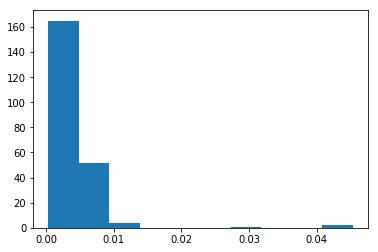

In [26]:
# threshold for a manageable number of features
plt.hist(myModel.feature_importances_[myModel.feature_importances_>0])
important_indices = np.where(myModel.feature_importances_>0.005)[0]
print(important_indices)

In [27]:
np.where(myModel.feature_importances_>0.005)

(array([  36,  205,  402,  883, 1018, 1019, 1042, 1050, 1056, 1165, 1168,
        1173, 1189, 1190, 1191, 1215, 1226, 1294, 1312, 1441, 1477, 1488,
        1511, 1512, 1516, 1518, 1539, 1548, 1549, 1550, 1849, 1856, 1858,
        1879, 1881, 1889, 1891, 1911, 1921, 1927, 1932, 1942, 1947, 1949,
        1962, 1974, 1975, 1985, 1992, 1993, 1995, 2006, 2010, 2039]),)

### Model for entire data

In [28]:
# load entire dataset for these features. 
# note where the feature indices are split so we can load the correct ones straight from read_csv
n_date_features = 1156
X_full = np.concatenate([
    pd.read_csv(zf1.open("train_date.csv"), index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices < n_date_features] + 1])).values,
    pd.read_csv(zf2.open("train_numeric.csv"), index_col=0, dtype=np.float32,
                usecols=np.concatenate([[0], important_indices[important_indices >= n_date_features] + 1 - 1156])).values
                ], axis=1)
y_full = pd.read_csv(zf2.open("train_numeric.csv"), index_col=0, dtype=np.float32, usecols=[0,969]).values.ravel()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [29]:
clf_full_data = XGBClassifier(max_depth=5, base_score=0.005)
skf = StratifiedKFold()
skf.get_n_splits(X_full, y_full)
preds = np.ones(y_full.shape[0])

for train_index, test_index in skf.split(X_full, y_full):
    print("TRAIN:", train_index, "TEST:", test_index)
    #X_train, X_test = X[train_index], X[test_index]
    #y_train, y_test = y[train_index], y[test_index]
    
    preds[test_index] = clf_full_data.fit(X_full[train_index], y_full[train_index]).predict_proba(X_full[test_index])[:,1]
    print("ROC AUC: ", roc_auc_score(y_full[test_index], preds[test_index]))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:629: FutureWarning: The default value of n_split will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(NSPLIT_WARNING, FutureWarning)


TRAIN: [ 394571  394572  394573 ... 1183744 1183745 1183746] TEST: [     0      1      2 ... 395664 395665 395695]
ROC AUC:  0.7258777863733405
TRAIN: [      0       1       2 ... 1183744 1183745 1183746] TEST: [394571 394572 394573 ... 790831 790909 790942]
ROC AUC:  0.7047022699007283
TRAIN: [     0      1      2 ... 790831 790909 790942] TEST: [ 789150  789151  789152 ... 1183744 1183745 1183746]
ROC AUC:  0.69761564050326


In [30]:
print(roc_auc_score(y_full, preds))

0.7090342529625953


### Save Model - Full Data

In [0]:
# save the model to disk
filename = 'XGBoost_Model_Full_Data.sav'
pickle.dump(clf_full_data, open(filename, 'wb'))

### Load Model - Full Data

In [0]:
# load the model from disk
clf_full_data = pickle.load(open(filename, 'rb'))

### Best Threshold Selection

0.20415193242539573


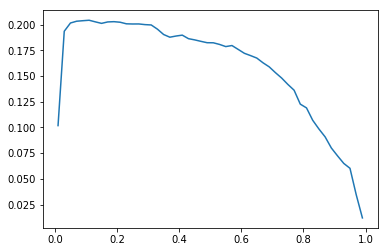

In [33]:
# pick the best threshold out-of-fold
thresholds = np.linspace(0.01, 0.99, 50)
mcc = np.array([matthews_corrcoef(y_full, preds>thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [0]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [35]:
confusion_matrix(y_full, preds>0.08)

array([[1172705,    4163],
       [   5613,    1266]])

In [36]:
y_full.shape

(1183747,)

In [37]:
y_full.sum()

6879.0

In [38]:
preds[preds>.02].shape

(9301,)

In [0]:
fpr, tpr, threshold = roc_curve(y_full, preds)
roc_auc = auc(fpr, tpr)

In [0]:
%config InlineBackend.figure_format = 'retina'

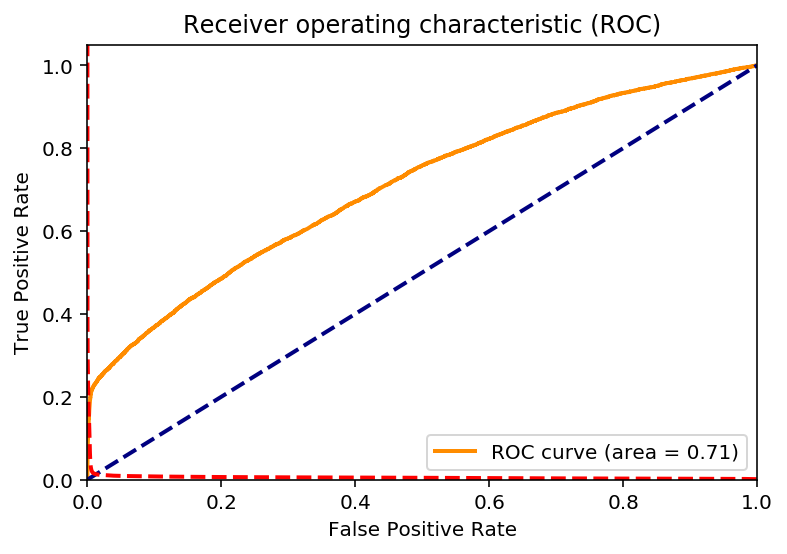

In [41]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr, threshold, color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

(0.0, 0.02)

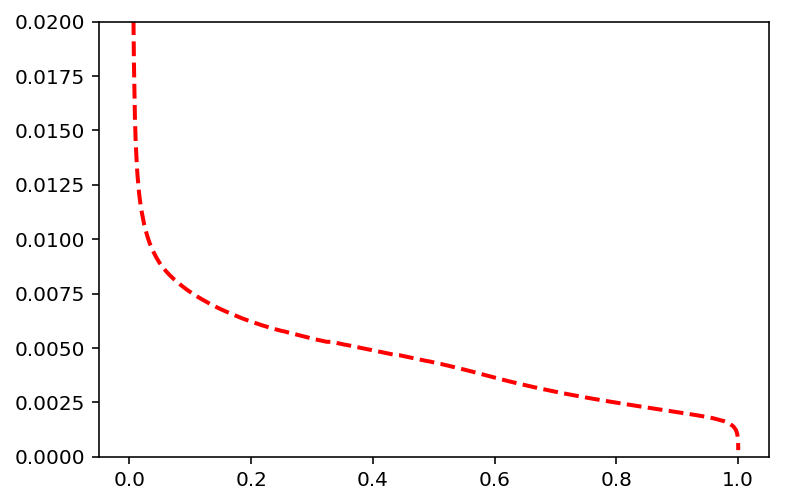

In [42]:
plt.plot(fpr, threshold, color='red', lw=2, linestyle='--')
plt.ylim([0.0, 0.02])